In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import loadtxt
import scipy as sp
import pickle

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot
from matplotlib import pyplot as plt
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit
from scipy.stats import pearsonr
from matplotlib import pyplot

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import xgboost as xgb
from xgboost import plot_importance

from tqdm.notebook import trange, tqdm
import torch.optim as optim
import time
import torch
import torch.nn as nn
import torch.utils.data as data

In [ ]:
count_df = pd.read_csv('/content/drive/MyDrive/Penn_work/counts.cts', sep='\t')
engraftment_df = pd.read_csv('/content/drive/MyDrive/Penn_work/Engraftment_Sheet2.tsv', sep='\t')

In [ ]:
count_df.head()

,Genes,14415-27,14415-20,14415-19,14415-33,14415-32,14415-23,14415-34,14415-29,14415-30.,...,14415-02,14415-03,14415-04,14415-07,14415-08,14415-09,14415-10,14415-11,14415-12,14415-13
0,A1BG,138,100,141,88,66,81,80,84,124,...,233,184,183,156,253,158,157,196,143,164
1,A1CF,2,1,2,2,0,1,2,1,5,...,3,5,0,8,2,5,0,4,0,1
2,A2M,3,1,3,8,8,10,3,7,21,...,1,12,3,4,5,6,2,6,0,3
3,A2ML1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,A3GALT2,1,2,4,1,0,2,1,0,0,...,1,6,0,1,4,2,0,1,0,0


In [ ]:
unlabelled_patient_ids = np.take(np.array(count_df.columns), [9,11,13,14,16,20,26,27], axis = 0)
print(unlabelled_patient_ids)

['14415-30.' '14415-22' '14415-26' '14415-14' '14415-16' '14415-04'
 '14415-12' '14415-13']


In [ ]:
engraftment_df.rename(columns={'Cell': 'Patient'}, inplace = True)
engraftment_df.head()

,Patient,Engraftment,Cohort,CAR_GIVEN
0,14415-27,h,3,5.0
1,14415-20,h,3,5.0
2,14415-19,l,3,5.0
3,14415-33,h,3,5.0
4,14415-32,h,3,5.0


In [ ]:
#Replacing h with 1 and l with 0 in engraftment data frame
engraftmet_df_temp = engraftment_df[~engraftment_df.Patient.isin(['14415-12', '14415-13', '14415-16', '14415-14', '14415-22'])]
new_engraftment = engraftmet_df_temp.Engraftment.eq('h').mul(1)
labels_df = pd.concat([new_engraftment, engraftmet_df_temp['Patient']], axis = 1)
engraftment_labels = list(labels_df['Engraftment'])

#Percent of 0's/lows in engraftment labels
percent_zeroes = engraftment_labels.count(0)/len(engraftment_labels)
percent_zeroes

0.5263157894736842

In [ ]:
missing_labels_df = pd.DataFrame()
missing_labels_df['Patient'] = unlabelled_patient_ids
missing_labels_df['Engraftment'] = len(unlabelled_patient_ids)*['NA']
missing_labels_df.head()

,Patient,Engraftment
0,14415-30.,NA
1,14415-22,NA
2,14415-26,NA
3,14415-14,NA
4,14415-16,NA


In [ ]:
#Standardizing by rows
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

standardized_df = mean_norm(count_df.iloc[:,1:])
standardized_df

,14415-27,14415-20,14415-19,14415-33,14415-32,14415-23,14415-34,14415-29,14415-30.,14415-21,...,14415-02,14415-03,14415-04,14415-07,14415-08,14415-09,14415-10,14415-11,14415-12,14415-13
0,-0.264270,-0.280881,-0.262051,-0.272915,-0.264946,-0.258595,-0.258684,-0.281366,-0.298561,-0.280675,...,-0.231947,-0.238205,-0.230771,-0.248883,-0.194750,-0.248048,-0.238486,-0.221387,-0.236745,-0.212476
1,-0.314714,-0.333951,-0.303858,-0.315597,-0.289851,-0.290072,-0.284065,-0.315809,-0.347100,-0.303810,...,-0.285202,-0.280142,-0.293738,-0.292371,-0.274909,-0.302190,-0.294873,-0.276450,-0.275233,-0.287469
2,-0.314343,-0.333951,-0.303557,-0.312619,-0.286833,-0.286531,-0.283740,-0.313319,-0.340574,-0.299853,...,-0.285665,-0.278502,-0.292706,-0.293546,-0.273951,-0.301836,-0.294154,-0.275876,-0.275233,-0.286549
3,-0.315456,-0.334487,-0.304158,-0.316590,-0.289851,-0.290465,-0.284716,-0.316224,-0.349140,-0.304419,...,-0.285897,-0.281314,-0.293394,-0.294721,-0.275548,-0.303959,-0.294873,-0.277310,-0.275233,-0.287929
4,-0.315085,-0.333415,-0.303256,-0.316094,-0.289851,-0.289678,-0.284390,-0.316224,-0.349140,-0.304419,...,-0.285665,-0.279908,-0.293738,-0.294428,-0.274271,-0.303252,-0.294873,-0.277310,-0.275233,-0.287929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19261,-0.309892,-0.325374,-0.293030,-0.310634,-0.284946,-0.285350,-0.281462,-0.311659,-0.342205,-0.301679,...,-0.275477,-0.276394,-0.282383,-0.286788,-0.260857,-0.302544,-0.288049,-0.275016,-0.273887,-0.259404
19262,-0.072509,-0.084679,-0.099636,-0.081339,-0.073631,-0.096490,-0.105748,-0.049813,-0.126838,-0.083721,...,-0.175451,-0.128325,-0.167460,-0.147805,-0.193153,-0.180458,-0.216577,-0.172348,-0.138506,-0.200054
19263,0.957881,0.948863,0.705521,0.714245,1.117655,1.057523,0.830740,0.741536,0.807643,0.785067,...,1.012360,1.441159,1.193733,1.128021,0.913747,0.892839,1.426182,1.399218,1.166856,1.008568
19264,0.406708,0.443885,0.435431,0.327124,0.447109,0.350872,0.278869,0.470145,0.622868,0.398161,...,0.338804,0.409362,0.391675,0.424877,0.226805,0.397771,0.307066,0.340132,0.348650,0.384244


In [ ]:
#Transposing data so that patients are rows and genes are columns (PCA maintains rows/patients)
def transpose(df, count_data = count_df):
  if 'Genes' in df.columns:
    df.drop('Genes', axis = 1, inplace = True)
  tranposed_data = df.T
  tranposed_data.columns = list(count_data['Genes'])
  return tranposed_data

prepped_data = transpose(standardized_df)
prepped_data.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
14415-27,-0.264270,-0.314714,-0.314343,-0.315456,-0.315085,-0.310634,-0.315456,0.014655,0.007979,-0.315456,...,0.127412,0.615159,-0.276139,-0.194539,-0.069542,-0.309892,-0.072509,0.957881,0.406708,-0.034676
14415-20,-0.280881,-0.333951,-0.333951,-0.334487,-0.333415,-0.332343,-0.333951,0.028432,0.061668,-0.334487,...,0.165665,0.754806,-0.274448,-0.168306,-0.026784,-0.325374,-0.084679,0.948863,0.443885,-0.025711
14415-19,-0.262051,-0.303858,-0.303557,-0.304158,-0.303256,-0.304158,-0.304459,0.114511,-0.056927,-0.304459,...,0.201133,0.933203,-0.262051,-0.175730,-0.045197,-0.293030,-0.099636,0.705521,0.435431,0.018867
14415-33,-0.272915,-0.315597,-0.312619,-0.316590,-0.316094,-0.313612,-0.316590,0.034301,-0.022278,-0.316590,...,0.182201,0.625902,-0.266463,-0.158267,-0.052057,-0.310634,-0.081339,0.714245,0.327124,-0.033197
14415-32,-0.264946,-0.289851,-0.286833,-0.289851,-0.289851,-0.288719,-0.289851,-0.030236,-0.012878,-0.289851,...,0.143344,0.641820,-0.257022,-0.171742,-0.095517,-0.284946,-0.073631,1.117655,0.447109,-0.008350


In [ ]:
#Dimensionality reduction
pca = PCA(n_components=27)
reduced_data = pca.fit_transform(prepped_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.



In [ ]:
pca_df = pd.DataFrame(reduced_data)
pca_df.index = prepped_data.index

all_labels_df = pd.concat([missing_labels_df, labels_df])


fig = px.imshow(pca_df, labels=dict(x="Dimensionally Reduced Genes", y="Patients"))
fig.show()

#pca_df

#do this in r, add side bar and find pca equations

In [ ]:
#Splitting data into patients with engraftment label and without
#labelled_patients = row indices of patients with engraftment data
def split_by_label(data):
  unlabelled_patients = np.array([8,10,12,13,15,19,25,26])
  labelled_patients = [i for i in range(27) if i not in unlabelled_patients]
  unlabelled_data = np.take(data, unlabelled_patients, axis = 0)
  labelled_data = np.take(data, labelled_patients, axis = 0)
  return unlabelled_data, labelled_data

unlabelled_reduced_data, labelled_reduced_data = split_by_label(reduced_data)

In [ ]:
clf = svm.SVC(kernel='linear', C=1, random_state=42)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(clf, labelled_reduced_data, engraftment_labels, cv=cv, scoring='accuracy')
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

for train_index, test_index in cv.split(labelled_reduced_data, engraftment_labels):
  print("TRAIN:", train_index, "TEST:", test_index)

[0.5  0.75 0.75 0.5  1.  ]
0.70 accuracy with a standard deviation of 0.19
TRAIN: [ 0  1  2  3  4  5  6  7  9 11 12 13 14 15 17] TEST: [ 8 10 16 18]
TRAIN: [ 0  3  4  5  6  8  9 10 11 12 14 15 16 17 18] TEST: [ 1  2  7 13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 13 16 17 18] TEST: [11 12 14 15]
TRAIN: [ 0  1  2  5  7  8 10 11 12 13 14 15 16 17 18] TEST: [3 4 6 9]
TRAIN: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 18] TEST: [ 0  5 17]


Ideal: 0.684
> folds=2, accuracy=0.683 (0.667,0.700)
> folds=3, accuracy=0.627 (0.500,0.714)
> folds=4, accuracy=0.525 (0.400,0.800)
> folds=5, accuracy=0.700 (0.500,1.000)
> folds=6, accuracy=0.694 (0.333,1.000)
> folds=7, accuracy=0.643 (0.333,1.000)
> folds=8, accuracy=0.625 (0.000,1.000)


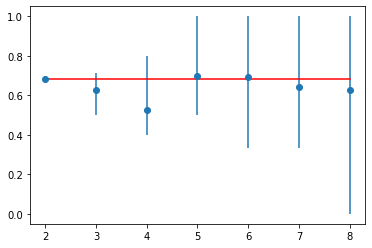

In [ ]:
def get_model():
	model = svm.SVC(kernel='linear', C=1, random_state=42)
	return model

# evaluate the model using a given test condition
def evaluate_model(cv, X, y):
	model = get_model()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut(), labelled_reduced_data, engraftment_labels)
print('Ideal: %.3f' % ideal)

# define folds to test
folds = range(2,9)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
  cv = StratifiedKFold(n_splits=k, random_state=1, shuffle=True)
  k_mean, k_min, k_max = evaluate_model(cv, labelled_reduced_data, engraftment_labels)
  print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
  means.append(k_mean)
  mins.append(k_mean - k_min)
  maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
pyplot.show()

>LogisticRegression: ideal=0.737, cv=0.700
>RidgeClassifier: ideal=0.737, cv=0.700
>SGDClassifier: ideal=0.579, cv=0.583
>PassiveAggressiveClassifier: ideal=0.684, cv=0.700
>KNeighborsClassifier: ideal=0.474, cv=0.533
>DecisionTreeClassifier: ideal=0.368, cv=0.517
>ExtraTreeClassifier: ideal=0.421, cv=0.467
>LinearSVC: ideal=0.632, cv=0.683
>SVC: ideal=0.368, cv=0.533
>GaussianNB: ideal=0.421, cv=0.517
>AdaBoostClassifier: ideal=0.368, cv=0.267
>BaggingClassifier: ideal=0.579, cv=0.583
>RandomForestClassifier: ideal=0.474, cv=0.467
>ExtraTreesClassifier: ideal=0.316, cv=0.733
>GaussianProcessClassifier: ideal=0.474, cv=0.467
>GradientBoostingClassifier: ideal=0.632, cv=0.517
>LinearDiscriminantAnalysis: ideal=0.526, cv=0.567
>QuadraticDiscriminantAnalysis: ideal=0.526, cv=0.367
Correlation: 0.499


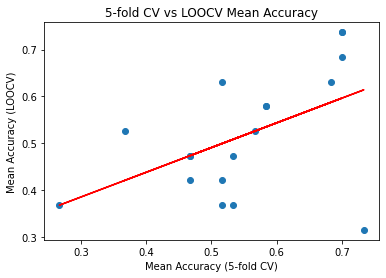

In [ ]:
# correlation between test harness and ideal test condition

# get a list of models to evaluate
def get_models():
	models = list()
	models.append(LogisticRegression())
	models.append(RidgeClassifier())
	models.append(SGDClassifier())
	models.append(PassiveAggressiveClassifier())
	models.append(KNeighborsClassifier())
	models.append(DecisionTreeClassifier())
	models.append(ExtraTreeClassifier())
	models.append(LinearSVC())
	models.append(SVC())
	models.append(GaussianNB())
	models.append(AdaBoostClassifier())
	models.append(BaggingClassifier())
	models.append(RandomForestClassifier())
	models.append(ExtraTreesClassifier())
	models.append(GaussianProcessClassifier())
	models.append(GradientBoostingClassifier())
	models.append(LinearDiscriminantAnalysis())
	models.append(QuadraticDiscriminantAnalysis())
	return models

# evaluate the model using a given test condition
def evaluate_model(cv, model, X, y):
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return mean(scores)

# define test conditions
ideal_cv = LeaveOneOut()
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
	# evaluate model using each test condition
	cv_mean = evaluate_model(cv, model, labelled_reduced_data, engraftment_labels)
	ideal_mean = evaluate_model(ideal_cv, model, labelled_reduced_data, engraftment_labels)
	# check for invalid results
	if isnan(cv_mean) or isnan(ideal_mean):
		continue
	# store results
	cv_results.append(cv_mean)
	ideal_results.append(ideal_mean)
	# summarize progress
	print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))
# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)
# scatter plot of results
pyplot.scatter(cv_results, ideal_results)
# plot the line of best fit
coeff, bias = polyfit(cv_results, ideal_results, 1)
line = coeff * asarray(cv_results) + bias
pyplot.plot(cv_results, line, color='r')
# label the plot
pyplot.title('5-fold CV vs LOOCV Mean Accuracy')
pyplot.xlabel('Mean Accuracy (5-fold CV)')
pyplot.ylabel('Mean Accuracy (LOOCV)')
# show the plot
pyplot.show()

In [ ]:
#sploitting data with engraftment labels into train and test
X_train, X_test, y_train, y_test = train_test_split(labelled_reduced_data, engraftment_labels, stratify = engraftment_labels, test_size=0.33, random_state=42)
print(X_train.shape)
print(len(y_train))

(12, 27)
12


In [ ]:
#Defining the parameters to search through them and find the best one
param_grid = {'C': [0.1, 1, 10, 100, 200, 500, 700, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']} 
  
#Searching using GridSearchCV
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
grid.fit(X_train, y_train)

#Getting the best parameters
#print(grid.best_params_)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.333 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.333 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.667 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.333 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.500 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.333 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

In [ ]:
#Training RF classifier on a subset of the labeled data (the train data), showing the confidence of the predictions

RF_subset_classifier = RandomForestClassifier(max_depth=2, random_state=0)
RF_subset_classifier.fit(X_train, y_train)
RF_class_probabilities = pd.DataFrame()
RF_class_probabilities['Class 0'] = RF_subset_classifier.predict_proba(X_test)[:,0]
RF_class_probabilities['Class 1'] = RF_subset_classifier.predict_proba(X_test)[:,1]
RF_class_probabilities['True Labels'] = y_test
#Change sample to patient id
RF_class_probabilities['Sample'] = ['Sample ' + str(i) for i in range(7)]
RF_class_probabilities.head()

,Class 0,Class 1,True Labels,Sample
0,0.721389,0.278611,0,Sample 0
1,0.637877,0.362123,1,Sample 1
2,0.483889,0.516111,0,Sample 2
3,0.592460,0.407540,1,Sample 3
4,0.484127,0.515873,0,Sample 4


In [ ]:
#Plotting the probabilities of classes for the RF
bar_plot_df = pd.DataFrame()
bar_plot_df['Probability'] = list(RF_class_probabilities['Class 0']) + list(RF_class_probabilities['Class 1'])
bar_plot_df['Sample'] = 2*list(RF_class_probabilities['Sample'])
bar_plot_df['Class'] = 7*['Class 0'] + 7*['Class 1']
fig = px.bar(bar_plot_df, x='Probability', y = 'Sample', color='Class', orientation='h', title='Confidence of RF Model Predictions')
fig.show()

#show correct engraftment next to patient id

In [ ]:
#Training a random forest on all labelled data to predict unlabeled data
RF_accuracies = list()
RF_classifier = RandomForestClassifier(max_depth=2, random_state=0)
RF_classifier.fit(labelled_reduced_data, engraftment_labels)

for i in range(13):
  RF_prediction = RF_classifier.predict([labelled_reduced_data[i]])
  RF_accuracy = sum(RF_prediction == [engraftment_labels[i]])/len(RF_prediction)
  RF_accuracies.append(RF_accuracy)

#Printing accuracies for labeled data (the model was trained on labeled data so accuracies are one as expected)
print(RF_accuracies)

#Adding the predicted labels for the unlabeled data into a dataframe
RF_unlabelled_predictions = RF_classifier.predict(unlabelled_reduced_data)
unlabelled_pred_df = pd.DataFrame()
unlabelled_pred_df['Patient'] = unlabelled_patient_ids
unlabelled_pred_df['RF Prediction'] = RF_unlabelled_predictions

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
#Training logistic regression on all labeled data
LR_classifier = LogisticRegression(random_state=0).fit(labelled_reduced_data, engraftment_labels)
LR_accuracies = list()

for i in range(13):
  logistic_pred = LR_classifier.predict([labelled_reduced_data[i]])
  LR_accuracy = sum(logistic_pred == engraftment_labels[i])/len(logistic_pred)
  LR_accuracies.append(LR_accuracy)

#Adding the predictions for the unlabelled data to the dataframe
LR_unlabelled_predictions = LR_classifier.predict(unlabelled_reduced_data)
unlabelled_pred_df['LR Prediction'] = LR_unlabelled_predictions

In [ ]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)
decision_tree_pred = decision_tree.predict(X_test)

decision_tree_accuracy = np.sum(decision_tree_pred == y_test)/len(decision_tree_pred)
print(decision_tree_accuracy)
#print decision tree

0.42857142857142855


In [ ]:
#Training xgboost model on training set of labeled data
#Metric is error (1 - accuracy)
param_dist = {'objective':'binary:logistic', 'n_estimators':2}

xgb_clf = xgb.XGBModel(**param_dist)

xgb_clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='error',
        verbose=True)

evals_result = xgb_clf.evals_result()

print('Access Error metric directly from validation_0:')
print(evals_result['validation_0']['error'])

print('')
print('Access metrics through a loop:')
for e_name, e_mtrs in evals_result.items():
    print('- {}'.format(e_name))
    for e_mtr_name, e_mtr_vals in e_mtrs.items():
        print('   - {}'.format(e_mtr_name))
        print('      - {}'.format(e_mtr_vals))

print('')
print('Access complete dict:')
print(evals_result)

#fix to lower training and high testing
#add validation set?
#add more metrics

[0]	validation_0-error:0.166667	validation_1-error:0.571429
[1]	validation_0-error:0	validation_1-error:0.571429
Access Error metric directly from validation_0:
[0.166667, 0.0]

Access metrics through a loop:
- validation_0
   - error
      - [0.166667, 0.0]
- validation_1
   - error
      - [0.571429, 0.571429]

Access complete dict:
{'validation_0': {'error': [0.166667, 0.0]}, 'validation_1': {'error': [0.571429, 0.571429]}}


In [ ]:
y_pred_xgb = xgb_clf.predict(X_test)
predictions_xgb = [round(value) for value in y_pred_xgb]
accuracy = accuracy_score(y_test, predictions_xgb)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 42.86%


In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

In [ ]:
param = {'max_depth': 1, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)
ypred = bst.predict(dtest)

[0]	eval-auc:0.375	train-auc:0.833333
[1]	eval-auc:0.5	train-auc:0.972222
[2]	eval-auc:0.375	train-auc:1
[3]	eval-auc:0.375	train-auc:1
[4]	eval-auc:0.375	train-auc:1
[5]	eval-auc:0.375	train-auc:1
[6]	eval-auc:0.375	train-auc:1
[7]	eval-auc:0.375	train-auc:1
[8]	eval-auc:0.375	train-auc:1
[9]	eval-auc:0.375	train-auc:1


In [ ]:
#Training xgboost on all labeled data and predicting unlabeled
unlabelled_pred_xgb = xgb_clf.predict(unlabelled_reduced_data)
unlabelled_predictions_xgb = [round(value) for value in unlabelled_pred_xgb]
unlabelled_pred_df['XGB Model'] = unlabelled_predictions_xgb

In [ ]:
unlabelled_pred_df

,Patient,RF Prediction,LR Prediction,XGB Model
0,14415-30.,1,1,1
1,14415-22,0,1,1
2,14415-26,0,1,0
3,14415-14,0,1,1
4,14415-16,1,1,0
5,14415-04,1,1,1
6,14415-12,1,1,0
7,14415-13,0,1,0


In [ ]:
## Moving into an MLP classifier

In [ ]:
#Making an iterator to go into the MLP
#Essentially takes batches of my data
def create_iterator(data_list, BATCH_SIZE = 3):
  iterator = data.DataLoader(data_list,
                            shuffle=True,
                            batch_size = BATCH_SIZE)
  return iterator

In [ ]:
#Shaping the data into the correct form
#The correct form is tuples that look like: (data for the patient, label for patient)
def make_data_tuples(X_data, y_data):
  data_list = list()
  X_torch = torch.from_numpy(X_data)
  for i, my_data in enumerate(X_data):
    data_list.append((my_data, y_data[i]))
  return data_list

train_list = make_data_tuples(X_train, y_train)
test_list = make_data_tuples(X_test, y_test)
train_list

[(array([ 3.06578702e+01,  7.95747083e+00, -8.39178532e+00,  4.57397914e-01,
          9.12352261e+00,  2.78926607e+00, -3.08190743e+00, -3.14224799e+00,
          2.42838087e-01,  1.86990274e+00, -1.09210388e+00, -3.57454481e+00,
         -5.29487306e+00,  5.75036304e-01,  5.93984736e-01, -1.43789542e+00,
         -3.34696472e+00,  1.70474846e+00,  1.06085707e+00,  2.94179787e+00,
         -4.07354325e-01, -7.81239816e-01,  1.20871273e+00,  1.25367147e+00,
         -7.48915918e-01,  2.17838340e-01,  6.31661123e-14]), 1),
 (array([ 1.15246898e+01, -9.42115805e+00,  1.66053902e+01,  5.50397561e+00,
          1.24021595e+00, -9.02251087e+00, -5.90850652e+00,  1.47401794e+00,
          5.64702503e+00, -2.33147856e+00,  5.87437215e+00, -9.94230204e-01,
         -1.46944812e+00,  1.37097757e+00, -2.07112694e+00, -6.98344977e-01,
         -3.79355983e-01, -2.33021467e+00,  1.76499992e-02,  2.22953974e-01,
          7.51719179e-01, -1.65120568e+00, -7.80595464e-01, -4.81962491e-01,
         -

In [ ]:
train_iterator = create_iterator(train_list)
test_iterator = create_iterator(test_list)

In [ ]:
#Defining MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 6)
        self.output_fc = nn.Linear(6, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h = self.input_fc(x.float())

        y_pred = self.output_fc(h)

        #y_pred = [batch size, output dim]

        return y_pred, h

INPUT_DIM = 27
OUTPUT_DIM = 2

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            y_pred, h = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
#fix model
EPOCHS = 4

history = {'Train': {'Accuracy': [], 'Loss': []}, 'Test': {'Accuracy': [], 'Loss': []}}

for epoch in trange(EPOCHS):

  start_time = time.monotonic()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
  history['Train']['Loss'].append(train_loss)
  history['Train']['Accuracy'].append(train_acc)

  end_time = time.monotonic()

epoch_mins, epoch_secs = epoch_time(start_time, end_time)

print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.165 | Train Acc: 100.00%


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

0.25
